<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Get-data" data-toc-modified-id="Get-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Get data</a></span></li><li><span><a href="#Create-dataloaders" data-toc-modified-id="Create-dataloaders-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Create dataloaders</a></span></li></ul></div>

# Get data

In [ ]:
from fastai2.vision.all import *
from fastcore.test import *
import pandas as pd


### Unzip data ###
path = Path('/home/rory/data/coco2017')
path_items = path.ls()
from zipfile import ZipFile
def unzip(*paths,dest):
    """Unzips files located at posixpaths to dest. Deps: zipfile, pathlib."""
    for path in paths:
        if path.suffix == '.zip':
            print(f"Unzipping: {path} ---> {dest}.")
            with ZipFile(path, 'r') as archive:
                archive.extractall(dest)
    new_items = set(dest.ls()) - set(paths)
    print("Finished. New items in dest:",*new_items,sep='\n')
# unzip(*path_items, dest=path)


### Get ims and annos ###
ims_train, annos_train = get_annotations(path/'annotations/instances_train2017.json')
ims_valid, annos_valid = get_annotations(path/'annotations/instances_val2017.json')
ims_train = list(map(lambda x: 'train2017/'+x,ims_train))
ims_valid = list(map(lambda x: 'val2017/'  +x,ims_valid))
ims    = ims_train + ims_valid
annos  = annos_train + annos_valid
bboxes = [i[0] for i in annos]
lbls   = [i[1] for i in annos]


### Process annos ###
def transpose(l): return list(zip(*l))
def bbox_area(anno_t): # takes a transposed anno
    b = anno_t[0]
    return((b[2]-b[0])*(b[3]-b[1])) # b-t * l-r
def sort_annos(o): return sorted(transpose(o), key=bbox_area, reverse=True)
sorted_annos = [sort_annos(a) for a in annos]
largest_anno = [i[0] for i in sorted_annos]
largest_bbox = [i[0] for i in largest_anno]
largest_lbl  = [i[1] for i in largest_anno]
is_valid     = [False]*len(ims_train) + [True]*len(ims_valid)

### Store outputs in dfd, df ###
dfd = {
    "im":ims,
    "annos":annos,
    "bboxes":bboxes,
    "lbls":lbls,
    "sorted_annos":sorted_annos,
    "anno":largest_anno,
    "bbox":largest_bbox,
    "lbl":largest_lbl,
    "is_valid":is_valid}
df_all = pd.DataFrame(dfd)

#  Create dataloaders

In [ ]:
df = pd.DataFrame(df_all[['im', 'bbox', 'lbl', 'is_valid']]
                     .sample(frac=.1)
                     .reset_index()
                     .drop(columns='index')        # Note that drop creates a copy, so using
                    ).copy()                       ## .copy() is reundant (but good practice).
df.head(3)

,im,bbox,lbl,is_valid
0,val2017/000000384616.jpg,"[371.3, 191.57, 453.09000000000003, 466.01]",fire hydrant,True
1,train2017/000000230936.jpg,"[400.0, 0.0, 609.78, 353.51]",boat,False
2,train2017/000000027307.jpg,"[377.98, 9.28, 505.3, 426.02]",person,False


In [ ]:
db = DataBlock(
    blocks=(ImageBlock, PointBlock),
    splitter=ColSplitter(),
    get_x=ColReader('im', pref=path),
    get_y=ColReader('bbox'),
    item_tfms=[PointScaler(), Resize(224, ResizeMethod.Squish), ToTensor()],
    batch_tfms=[IntToFloatTensor(), Normalize.from_stats(*imagenet_stats)],
    n_inp=1
)
dls = db.dataloaders(df)
xb,yb = dls.one_batch()
print(xb.shape, yb.shape)
# ib,bb,lb = dls.one_batch()
# print(ib.shape, bb.shape, lb.shape)

torch.Size([64, 3, 224, 224]) torch.Size([64, 2, 2])


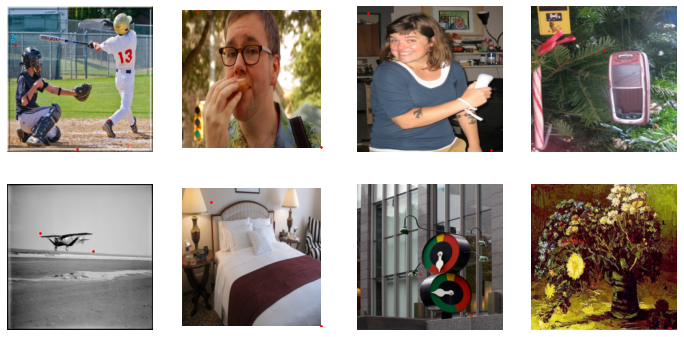

In [ ]:
dls.train.show_batch(max_n=8, nrows=2)

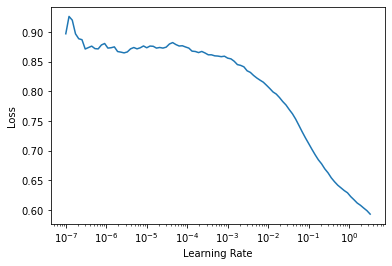

In [ ]:
learner = cnn_learner(dls, resnet18, y_range=(-1,1), batch_size=64)
lr_min,lr_steep = learner.lr_find()

In [ ]:
lr_min, lr_steep

(0.33113112449646, 0.0831763744354248)

In [ ]:
learner.fine_tune(3, lr=slice(.03,.5)) 

epoch,train_loss,valid_loss,time
0,0.396237,0.178944,00:14


epoch,train_loss,valid_loss,time
0,0.200525,0.138656,00:16
1,0.135152,0.110196,00:16
2,0.109149,0.105884,00:17


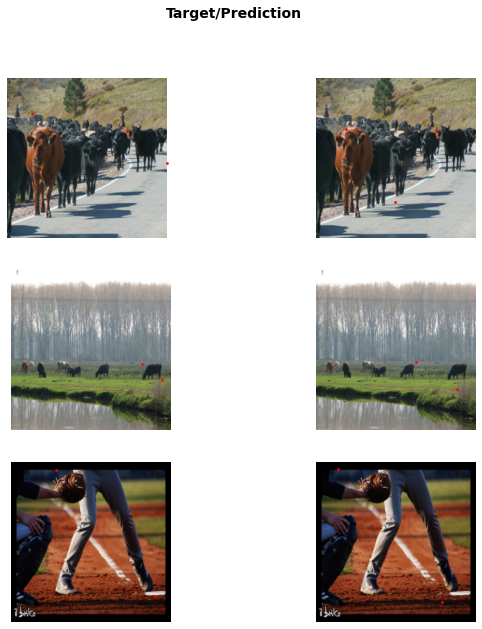

In [ ]:
learner.show_results(nrows=3,ncols=1, figsize=(10,10)) 